In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import numpy as np
import glob
from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from collections import deque
## Import everything from helpers
from helpers.utils import Utils
from helpers.filterFalsePositive import FilterFalsePositive
from helpers.classify import ClassifierUtil
% matplotlib inline


/Users/ankitgrover/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ankitgrover/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
## Load classifiers from pkl files
from sklearn.externals import joblib
svc = joblib.load('svcClassifier.pkl')
X_scaler = joblib.load('xScaler.pkl')

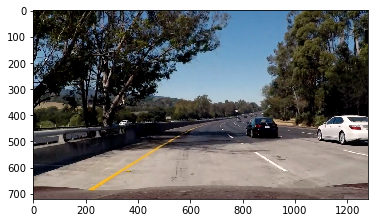

In [3]:
## Original testing image
img = mpimg.imread('test_images/test5.jpg')
plt.imshow(img)

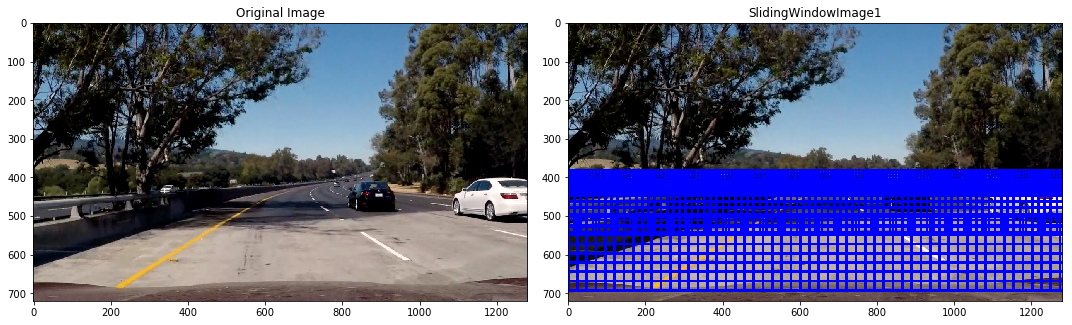

In [4]:
utils = Utils()
## Visualize Multiscale windows that can be used in identifying cars on different positions on the image.
scale_windows_list = []
scale_size = 4
y_starts = [380, 430, 500]
y_stops = [430, 520, 660]

for window_scale in range (1, scale_size):
    window_dimen = 32 * window_scale
    ##print (window_dimen)
    windows_list = utils.slide_window(img, x_start_stop=[None, None], y_start_stop=[y_starts[window_scale -1], y_stops[window_scale -1]], 
                    xy_window=(window_dimen, window_dimen), xy_overlap=(0.75, 0.75))
    if (len(scale_windows_list) == 0):
        scale_windows_list = windows_list
    else :
        scale_windows_list = scale_windows_list + windows_list
    
draw_img = np.copy(img)
for window in scale_windows_list:
    cv2.rectangle(draw_img, window[0], window[1],(0,0,255),6)
    
fig = plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(draw_img)
plt.title('SlidingWindowImage1')
fig.tight_layout()

In [5]:
## Actual Parameters are used to identify cars from the images.
y_start = 400
y_stop = 656
scale = 1.8
orient = 12
pix_per_cell = 8
cell_per_block = 4
spatial_size = (32, 32)
hist_bins = 128
## Queue to store previous heatmaps and then club them together in last image frame
## It helps in keeping car always under the heat blogs and removing false positives.
heat_images = deque(maxlen = 3)

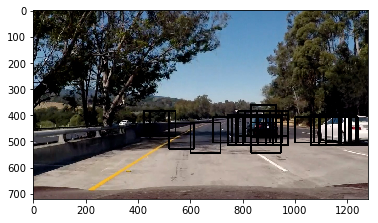

In [6]:
## Detect vehicles using VehicleDetector class and find_cars funtion. 
## It is using HOG Subsampling approach internally to find cars.
from helpers.vehicleDetector import VehicleDetector
vehicle_detector = VehicleDetector()
def find_cars(image):
    return vehicle_detector.find_cars(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window = 64)   
    
draw_img, bboxes = find_cars(img)
## Ouput of the test image frame
plt.imshow(draw_img)

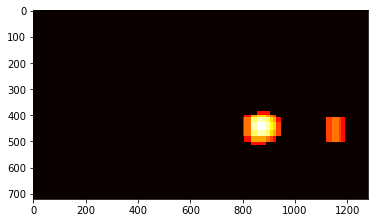

In [7]:
## Filter False positives using Heatmap and threshold.
def filter_false_positives(image, bboxes_list):
    filter_false_positive = FilterFalsePositive()
    heat = filter_false_positive.convert_img_to_heat(image)
    #print (bboxes)
    heatmap = filter_false_positive.add_heat(bboxes_list)
    ## Averaging last 3 heatmaps to smoothen the image frames output. 
    heat_images.append(heatmap)
    heatmap = np.sum(np.array(heat_images), axis = 0)
    heatmap = filter_false_positive.threshold(threshold = 5)
    return heatmap, filter_false_positive
    
heatmap, filter_false_positive = filter_false_positives(draw_img, bboxes)
plt.imshow(heatmap, cmap='hot')

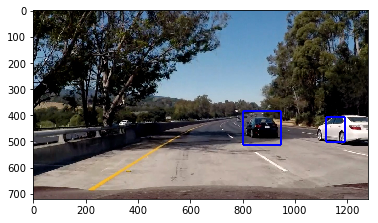

In [8]:
## Draw labels on the image frame after removing false positives.
## After thresholding only blobs of heat left around the cars positions.
def labels(image, filter_false_positive):
    filter_false_positive.labels()
    labeled_img = filter_false_positive.draw_labeled_bboxes(image)
    return labeled_img

labeled_img = labels(img, filter_false_positive)
plt.imshow(labeled_img)

In [9]:
## Pipeline to filter the cars from the images.
def process_image(frame):
    draw_img, bboxes = find_cars(frame)
    heatmap, filter_false_positive = filter_false_positives(frame, bboxes)
    output_frame = labels(frame, filter_false_positive)
    return output_frame

In [10]:
## Read Test video and ouput video with labels of Cars.
from moviepy.editor import VideoFileClip
output_video_path = 'output_video/test_video_output.mp4'
input_clip = VideoFileClip("test_video.mp4")
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_video/test_video_output.mp4
[MoviePy] Writing video output_video/test_video_output.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/test_video_output.mp4 

CPU times: user 11.4 s, sys: 1.29 s, total: 12.7 s
Wall time: 14.1 s


In [11]:
## Read Test video and ouput video with labels of Cars.
from moviepy.editor import VideoFileClip
output_video_path = 'output_video/project_video_output.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_video/project_video_output.mp4
[MoviePy] Writing video output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [07:19<00:00,  3.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 

CPU times: user 6min 25s, sys: 49.3 s, total: 7min 15s
Wall time: 7min 20s
